# Homework 3

In the final of the 3 homeworks we take *Gym CartPole*'s implementation as done in the lab, we look at how the exploration profile inpacts the learning curve. <br>
In the lab we implemented 2 different training loops: the first kept the reward as it is defined by the *Gym* library, the second (called advanced) implemented a linear penalty that discouraged the cart to go far from the center. In this notebook we use the advanced training loop in the first part, the "simple" one instead is never implemented. <br>
What we do next is to tweak model hyper-parameters and change how the reward is computed in order to achieve optimal performance in fewer steps.

In the first section that aims at looking at the difference between **Softmax** and **$\epsilon$-greedy** we use the same ReplayMemory, DQN, choose_action_epsilon_greedy and choose_action_softmax classes as defined in the lab.

Finally we study another *Gym* environment: the *Acrobot*, that will be described in the later sections of this network.

In [1]:
import torch
from torch import nn

In [2]:
import random
import numpy as np
#import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import deque # this python module implements exactly what we need for the replay memeory

In [3]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
import gym

# Experience replay (Replay Memory)

In [5]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        return self.memory.append((state, action, next_state, reward))
        #: Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

Test if it works as expected.

In [6]:
# Define the replay memory
replay_mem = ReplayMemory(capacity=3)

# Push some samples
print(f"Current memory size: {len(replay_mem)}")
replay_mem.push(1,1,1,1)
print(f"Current memory size: {len(replay_mem)}")
replay_mem.push(2,2,2,2)
print(f"Current memory size: {len(replay_mem)}")
replay_mem.push(3,3,3,3)
print(f"Current memory size: {len(replay_mem)}")
replay_mem.push(4,4,4,4)
print(f"Current memory size: {len(replay_mem)}")
replay_mem.push(5,5,5,5)
print(f"Current memory size: {len(replay_mem)}")

# Check the content of the memory
print('\nContent of the memory')
print(replay_mem.memory)

# Random sample
print('\nRandom sampling')
for i in range(5):
  print(replay_mem.sample(2)) # Select 2 samples randomly from the memory

Current memory size: 0
Current memory size: 1
Current memory size: 2
Current memory size: 3
Current memory size: 3
Current memory size: 3

Content of the memory
deque([(3, 3, 3, 3), (4, 4, 4, 4), (5, 5, 5, 5)], maxlen=3)

Random sampling
[(4, 4, 4, 4), (3, 3, 3, 3)]
[(3, 3, 3, 3), (5, 5, 5, 5)]
[(5, 5, 5, 5), (3, 3, 3, 3)]
[(3, 3, 3, 3), (5, 5, 5, 5)]
[(4, 4, 4, 4), (3, 3, 3, 3)]


# Policy network

The policy network takes a state as input, and provides the Q-value for each of the possible actions.

We define here a simple fully-connected feed forward neural network with `state_space_dim` inputs and `action_space_dim` outputs with a *Tanh* activation function.

## Network definition

In [7]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(in_features=state_space_dim, out_features = 128),
            nn.Tanh(),
            nn.Linear(in_features=128, out_features = 128),
            nn.Tanh(),
            nn.Linear(in_features=128, out_features = action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)

In [10]:
# Define an example network
net = DQN(state_space_dim=4, action_space_dim=2)

## Exploration Policy

Starting from the estimated Q-values (one for each action), we need to choose the proper action. This action may be the one expected to provide the highest long term reward (exploitation), or maybe we want to find a better policy by choosing a different action (exploration).

The exploration policy controls this behavior, typically by varying a single parameter.

Since our Q-values estimates are far from the true values at the beginning of the training, a high exploration is preferred in the initial phase.

### Epsilon-greedy policy

With an **$\epsilon$-greedy** policy we choose a **non optimal** action with probability epsilon, otherwise choose the best action (the one corresponding to the highest Q-value).

In [11]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    
    if random.random() < epsilon:
    
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
    
        action = best_action
        
    return action, net_out.numpy()

In [12]:
# Test if it works as expected
state = (0, 0, 0, 0)
epsilon = 0.5
chosen_action, q_values = choose_action_epsilon_greedy(net, state, epsilon)

print(f"Action: {chosen_action}")
print(f"Q-Values: {q_values}")

Action: 0
Q-Values: [-0.03107688  0.08101244]


### Softmax policy

In [13]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0) # Will return always the best action
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random 
    # element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [14]:
state = (0, 0, 0, 0)
temperature = 1
chosen_action, q_values = choose_action_softmax(net, state, temperature)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 0
Q-VALUES: [-0.03107688  0.08101244]


### Exploration profile and impact on the learning curve

Let's consider, for example, an exponentially decreasing exploration profile using a softmax policy.

$$
\text{softmax\_temperature}  = \text{initial\_temperature} * \text{exp\_decay}^i \qquad \text{for i = 1, 2, ..., num-iterations } 
$$


We also define an exploration profile to implement an **$\epsilon$-greedy** policy, we choose an initial value of 1 meaning that in the first step we are fully committed to exploration making our choice randomly.

$$
\text{$\epsilon\_value$}  = \text{$initial\_\epsilon$} * \text{$exp\_decay$}^i \qquad \text{for i = 1, 2, ..., num-iterations } 
$$


What we do next is to train, with the so called advanced training loop, our *CartPole* environment twice: in the first one we use a **Softmax** policy while in the other we use an **$\epsilon$-greedy** policy.<br>
For each of the training iteration we save the reward to show the learning curve.

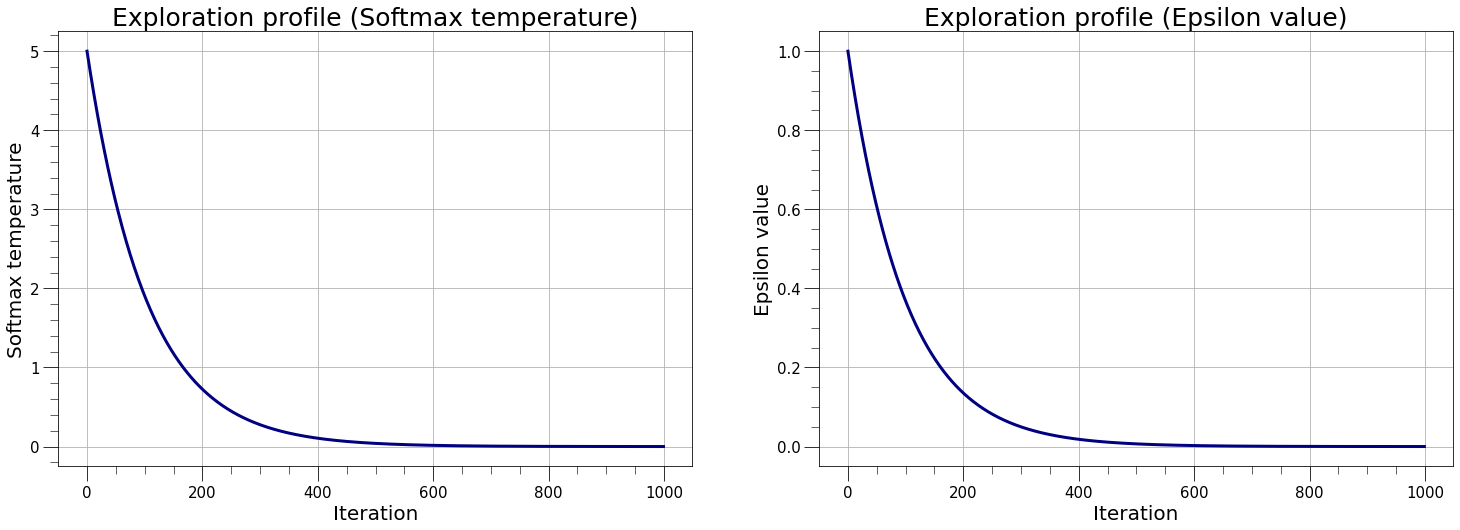

In [15]:
num_iterations = 1000


initial_value_soft = 5
exp_decay_soft = np.exp(-np.log(initial_value_soft) / num_iterations * 6) 

exploration_profile_soft = [initial_value_soft * (exp_decay_soft ** i) for i in range(num_iterations)]


initial_value_eps = 1
exp_decay_eps = np.exp(-initial_value_eps / num_iterations * 10) 
exploration_profile_eps = [initial_value_eps * (exp_decay_eps ** i) for i in range(num_iterations)]


# Plot exploration profile
fig, axs = plt.subplots(1, 2, figsize=(25, 8))
ax, ax_ = axs
ax.plot(exploration_profile_soft, color = 'navy', linewidth = 3)
ax.tick_params(axis='both', which='major', labelsize=15, length=15)
ax.tick_params(axis='both', which='minor', labelsize=15, length=8)
ax.minorticks_on()
ax.grid()
ax.set_xlabel('Iteration', fontsize = 20)
ax.set_ylabel('Softmax temperature', fontsize = 20)
ax.set_title('Exploration profile (Softmax temperature)', fontsize = 25)


ax_.plot(exploration_profile_eps, color = 'navy', linewidth = 3)
ax_.tick_params(axis='both', which='major', labelsize=15, length=15)
ax_.tick_params(axis='both', which='minor', labelsize=15, length=8)
ax_.minorticks_on()
ax_.grid()
ax_.set_xlabel('Iteration', fontsize = 20)
ax_.set_ylabel('Epsilon value', fontsize = 20)
ax_.set_title('Exploration profile (Epsilon value)', fontsize = 25)
plt.show()

# Gym Environment (CartPole-v1)

Let's describe now the *CartPole* environment, used in this first part of the notebook.

A pole is attached to a cart, which moves over a frictionless track. The pendulum is placed upright on the cart, the goal is to balance the pole by applying forces in the left and right direction on the cart.

### Action space

| Num | Action                 |
|:-----:|:------------------------:|
| 0   | Push cart to the left  |
| 1   | Push cart to the right |


### Observation Space
| Num | Observation           | Min                 | Max               |
|:-----:|:-----------------------:|:---------------------:|:-------------------:|
| 0   | Cart Position         | -4.8                | 4.8               |
| 1   | Cart Velocity         | -Inf                | Inf               |
| 2   | Pole Angle            | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
| 3   | Pole Angular Velocity | -Inf                | Inf               |


We have to notice here that although the cart x postition can take values in the open interval ($-4.8$, $4.8$) the episode terminates if the cart leaves the ($2.4$, $2.4$) range.

### Rewards
The goal is to keep the pole upright, a +1 reward then is allocated for each step.


### Starting State
All observations are assigned a uniformly random value in the open interval ($-0.05$, $0.05$)

## Episode End
The episode ends if any one of the following occurs:
- Termination: Pole Angle is greater than $±12°$
- Termination: Cart Position is greater than $±2.4$ (center of the cart reaches the edge of the display)
- Truncation: Episode length is greater than $500$

In [42]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"State space size: {state_space_dim}")
print(f"Action space size: {action_space_dim}")
print('Action space type:', env.action_space)

State space size: 4
Action space size: 2
Action space type: Discrete(2)


## Random agent

First of all, to check that the environment is working properly, let's try with an agent which simply choose an action randomly.

In [1]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)


# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done and score < 490:
      # Choose a random action
      action = random.choice([0, 1])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment (optional, comment this line to speed up the simulation)
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"Episode {num_episode + 1} - Final score: {score}") 

env.close()

# Network update

## Initialization

In [64]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# Parameters
gamma = 0.97   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [65]:
# Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

# Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

# Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

# Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

## Update function

In [22]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
    
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if 
    # the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()
    return loss

## Training loop 

In [68]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)
   




scores_soft = []
losses_soft = []
for episode_num, tau in enumerate(tqdm(exploration_profile_soft)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      
      # We apply a (linear) penalty when the cart is far from center
      pos_weight = 1
      reward = reward - pos_weight * np.abs(state[0]) 

      # Update the final score (+1 for each step)
      score += 1

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          loss = update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      #env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    
    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
    scores_soft.append(score)
    if len(replay_mem) > min_samples_for_training:
        losses_soft.append(loss)

env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.367737444559107
EPISODE: 16 - FINAL SCO

In [78]:
# Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

# Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

# Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

# Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

# Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

In [79]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 



scores_epsilon = []
losses_epsilon = []
for episode_num, eps in enumerate(tqdm(exploration_profile_eps)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_epsilon_greedy(policy_net, state, epsilon=eps)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # We apply a (linear) penalty when the cart is far from center
      pos_weight = 1
      reward = reward - pos_weight * np.abs(state[0]) 

      # Update the final score (+1 for each step)
      score += 1

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          loss = update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      #env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    
    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Epsilon: {eps}") # Print the final score
    scores_epsilon.append(score)
    if len(replay_mem) > min_samples_for_training:
        losses_epsilon.append(loss)

env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 9 - Epsilon: 1.0
EPISODE: 2 - FINAL SCORE: 11 - Epsilon: 0.9900498337491681
EPISODE: 3 - FINAL SCORE: 9 - Epsilon: 0.9801986733067554
EPISODE: 4 - FINAL SCORE: 9 - Epsilon: 0.9704455335485084
EPISODE: 5 - FINAL SCORE: 9 - Epsilon: 0.9607894391523234
EPISODE: 6 - FINAL SCORE: 9 - Epsilon: 0.9512294245007142
EPISODE: 7 - FINAL SCORE: 9 - Epsilon: 0.941764533584249
EPISODE: 8 - FINAL SCORE: 11 - Epsilon: 0.9323938199059486
EPISODE: 9 - FINAL SCORE: 9 - Epsilon: 0.9231163463866362
EPISODE: 10 - FINAL SCORE: 9 - Epsilon: 0.9139311852712286
Updating target network...
EPISODE: 11 - FINAL SCORE: 12 - Epsilon: 0.9048374180359601
EPISODE: 12 - FINAL SCORE: 10 - Epsilon: 0.8958341352965288
EPISODE: 13 - FINAL SCORE: 10 - Epsilon: 0.886920436717158
EPISODE: 14 - FINAL SCORE: 13 - Epsilon: 0.878095430920562
EPISODE: 15 - FINAL SCORE: 11 - Epsilon: 0.8693582353988065
EPISODE: 16 - FINAL SCORE: 14 - Epsilon: 0.8607079764250585
EPISODE: 17 - FINAL S

## Results

In the following we show the results of the training, for both the **Softmax** policy case and the **$\epsilon$-greedy** case. One imprtant thing we noticed is that the overall behaviour of the learning curve strongly depends on the specific run. To obtain an efficient picture of the overall situation we would be better-off doing some statistic on successive iterations.<br>
What we notice in our case is that in the **$\epsilon$-greedy** case we reach maximum performance much earlier but once it reaches $500$ the score average drops before rising up again later on, so we cannot conclude that with the **$\epsilon$-greedy** policy we solve the problem earlier than with the softmax policy.

Focusing on the **Softmax** curve we can see how, when the temperature is very low the score reaches and remains stable at a value of $500$ making it look like the problem is solved. 

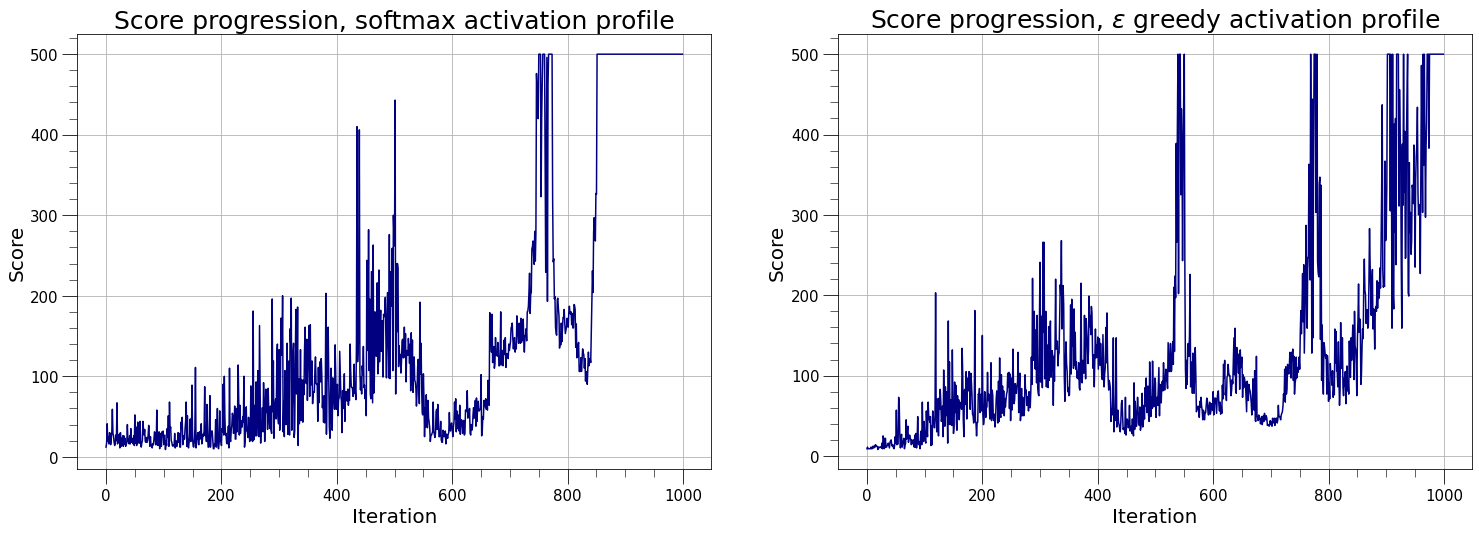

In [90]:
fig, axs = plt.subplots(1, 2, figsize = (25, 8))
ax1, ax2 = axs
ax1.plot(scores_soft, color = 'navy')
ax1.set_title('Score progression, softmax activation profile', fontsize = 25)

ax2.plot(scores_epsilon, color = 'navy')
ax2.set_title('Score progression, $\epsilon$ greedy activation profile', fontsize = 25)


for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=15, length=15)
    ax.tick_params(axis='both', which='minor', labelsize=15, length=8)
    ax.minorticks_on()
    ax.set_ylabel('Score', fontsize = 20)
    ax.set_xlabel('Iteration', fontsize = 20)
    ax.grid()
    



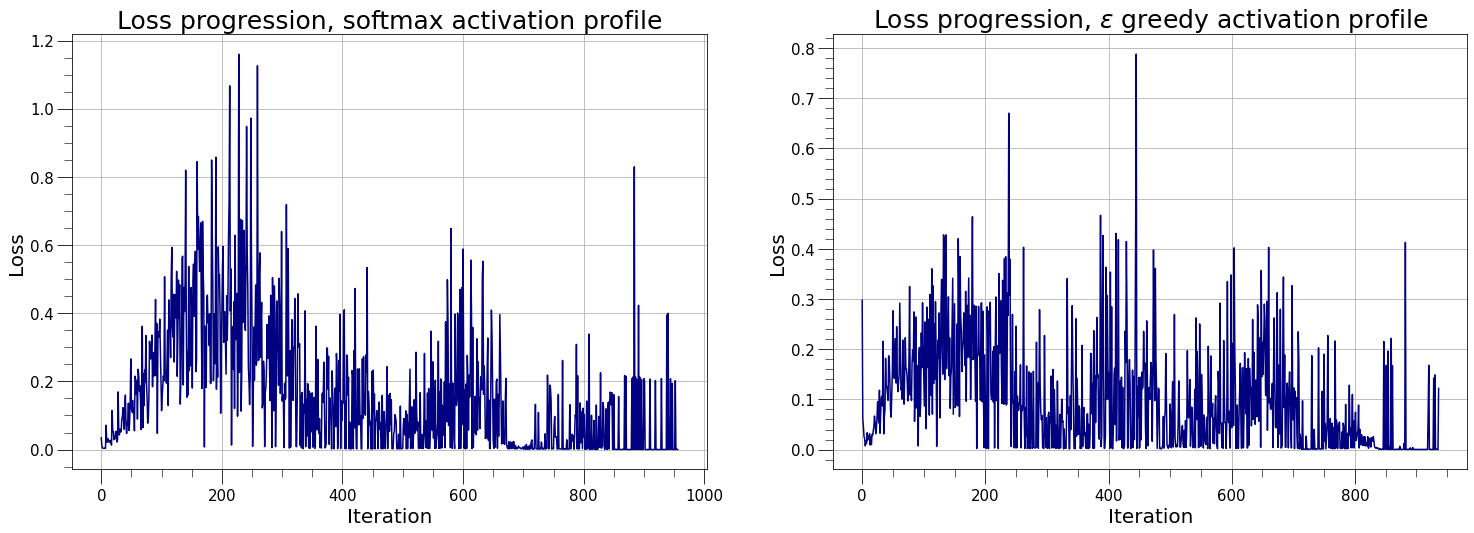

In [92]:
fig, axs = plt.subplots(1, 2, figsize = (25, 8))
ax1, ax2 = axs
ax1.plot(list(map(lambda x: x.detach().numpy(),losses_soft)), color = 'navy')
ax1.set_title('Loss progression, softmax activation profile', fontsize = 25)

ax2.plot(list(map(lambda x: x.detach().numpy(),losses_epsilon)), color = 'navy')
ax2.set_title('Loss progression, $\epsilon$ greedy activation profile', fontsize = 25)


for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=15, length=15)
    ax.tick_params(axis='both', which='minor', labelsize=15, length=8)
    ax.minorticks_on()
    ax.set_ylabel('Loss', fontsize = 20)
    ax.set_xlabel('Iteration', fontsize = 20)
    ax.grid()
    



## Speed-up of the learning convergence

In this section of the notebook we aim at speeding up the learning convergence by tweaking up a little bit the model, we sum-up what we did in the following.

1. **Optimizer:** In the previous case the optimizer was a standard Stochastic Gradient Descent (**SGD**) optimizer, now we define Adam as the optimizer thanks to the *PyTorch* library.

2. **Bad state penalty:** In the previous training loop we set the `bad_state_penalty` parameter to $0$, now we set it to `bad_state_penalty = -0.2`

3. **Reward:** What was new in the "Advanced" training loop was to impose a linear penalty to positions far from the center. What we do now is to introduce 2 new penalty terms: the first one punishes linearly angles from the vertical that are distant from 0, that is, when the pole is completely upright. In the second place we impose an additional penalty that discourages positions in which both the pole has a high linear velocity and a high angular one, encoding this feature with the product of the 2 terms: `vel_ang_vel_weight * np.abs(state[1])*np.abs(state[3])`

We do what we decribed above both using a **Softmax** policy and an **$\epsilon$-greedy** policy comparing the new performance with the one obtained without any tweaks.

In [93]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

bad_state_penalty = -0.2

In [94]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)
   



scores_tuning = []
losses_tuning = []
for episode_num, tau in enumerate(tqdm(exploration_profile_soft)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      
      # We apply a (linear) penalty when the cart is far from center
      pos_weight = 1
      angl_weight = 1
      vel_ang_vel_weight = 0.5
      reward = reward - pos_weight * np.abs(state[0]) - angl_weight * np.abs(state[2]) - \
        vel_ang_vel_weight * np.abs(state[1])*np.abs(state[3])

      # Update the final score (+1 for each step)
      score += 1

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          loss = update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      #env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    
    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
    scores_tuning.append(score)
    if len(replay_mem) > min_samples_for_training:
        losses_tuning.append(loss)

env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 20 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 12 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 9 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 12 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 10 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: 28 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 20 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 33 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 14 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 11 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 33 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 19 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 44 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: 13 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: 24 - Temperature: 4.367737444559107
EPISODE: 16 - FINAL SCOR

In [102]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr) # The optimizer will update 
# ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

bad_state_penalty = -0.2

In [103]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)
   



scores_tuning_eps = []
losses_tuning_eps = []
for episode_num, eps in enumerate(tqdm(exploration_profile_eps)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_epsilon_greedy(policy_net, state, epsilon=eps)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      
      # We apply a (linear) penalty when the cart is far from center
      pos_weight = 1
      angl_weight = 1
      vel_ang_vel_weight = 0.5
      reward = reward - pos_weight * np.abs(state[0]) - angl_weight * np.abs(state[2]) - \
        vel_ang_vel_weight * np.abs(state[1])*np.abs(state[3])

      # Update the final score (+1 for each step)
      score += 1

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          loss = update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      #env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the
        # policy network to the target network

    
    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Epsilon: {eps}") # Print the final score
    scores_tuning_eps.append(score)
    if len(replay_mem) > min_samples_for_training:
        losses_tuning_eps.append(loss)

env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 9 - Epsilon: 1.0
EPISODE: 2 - FINAL SCORE: 10 - Epsilon: 0.9900498337491681
EPISODE: 3 - FINAL SCORE: 10 - Epsilon: 0.9801986733067554
EPISODE: 4 - FINAL SCORE: 8 - Epsilon: 0.9704455335485084
EPISODE: 5 - FINAL SCORE: 11 - Epsilon: 0.9607894391523234
EPISODE: 6 - FINAL SCORE: 9 - Epsilon: 0.9512294245007142
EPISODE: 7 - FINAL SCORE: 13 - Epsilon: 0.941764533584249
EPISODE: 8 - FINAL SCORE: 10 - Epsilon: 0.9323938199059486
EPISODE: 9 - FINAL SCORE: 10 - Epsilon: 0.9231163463866362
EPISODE: 10 - FINAL SCORE: 9 - Epsilon: 0.9139311852712286
Updating target network...
EPISODE: 11 - FINAL SCORE: 11 - Epsilon: 0.9048374180359601
EPISODE: 12 - FINAL SCORE: 10 - Epsilon: 0.8958341352965288
EPISODE: 13 - FINAL SCORE: 17 - Epsilon: 0.886920436717158
EPISODE: 14 - FINAL SCORE: 11 - Epsilon: 0.878095430920562
EPISODE: 15 - FINAL SCORE: 10 - Epsilon: 0.8693582353988065
EPISODE: 16 - FINAL SCORE: 13 - Epsilon: 0.8607079764250585
EPISODE: 17 - FIN

## Results

Looking at how the score progresses, it jumps out immediately how the so called "improved model" not only reaches the 500 score mark much earlyer but, in both cases, the average score remains fairly high pointing at a better overall performance.

Next, what we represent are both the number of iterations needed to reach a score of $500$ and the average sore after hitting the maximum. We can see that, if we look at the model before the improvements, the **$\epsilon$-greedy** implementation raches the maximum much earlyer but that's balanced out by the fact that it has a low average after that.<br>
Focusing instead on the improved set-up we notice both the low number of iterations needed to hit $500$ and the high average after that point.

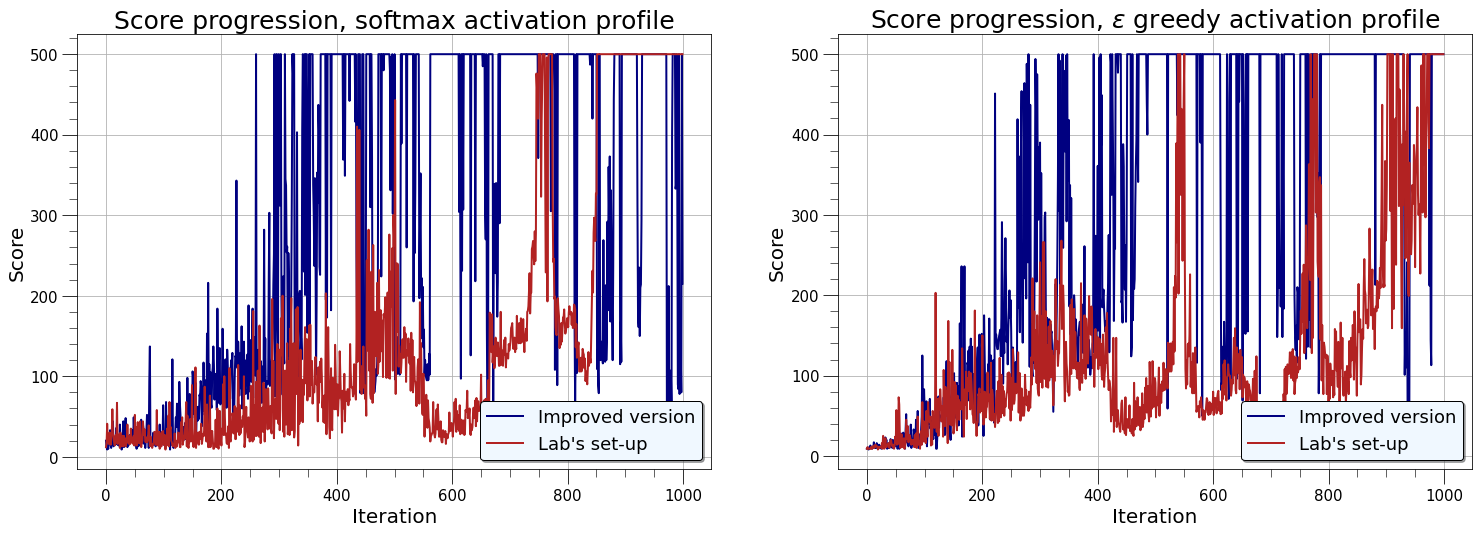

In [113]:
fig, axs = plt.subplots(1, 2, figsize = (25, 8))
ax1, ax2 = axs
ax1.plot(scores_tuning, color = 'navy', linewidth = 2, label='Improved version')
ax1.plot(scores_soft, color = 'firebrick', linewidth = 2, label='Lab\'s set-up')
ax1.set_title('Score progression, softmax activation profile', fontsize = 25)

ax2.plot(scores_tuning_eps, color = 'navy', linewidth = 2, label='Improved version')
ax2.plot(scores_epsilon, color = 'firebrick', linewidth = 2, label='Lab\'s set-up')
ax2.set_title('Score progression, $\epsilon$ greedy activation profile', fontsize = 25)


for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=15, length=15)
    ax.tick_params(axis='both', which='minor', labelsize=15, length=8)
    ax.minorticks_on()
    ax.set_ylabel('Score', fontsize = 20)
    ax.set_xlabel('Iteration', fontsize = 20)
    ax.grid()
    ax.legend(facecolor = 'aliceblue', shadow = True, edgecolor = 'black', fontsize =18, loc = 'lower right')
    



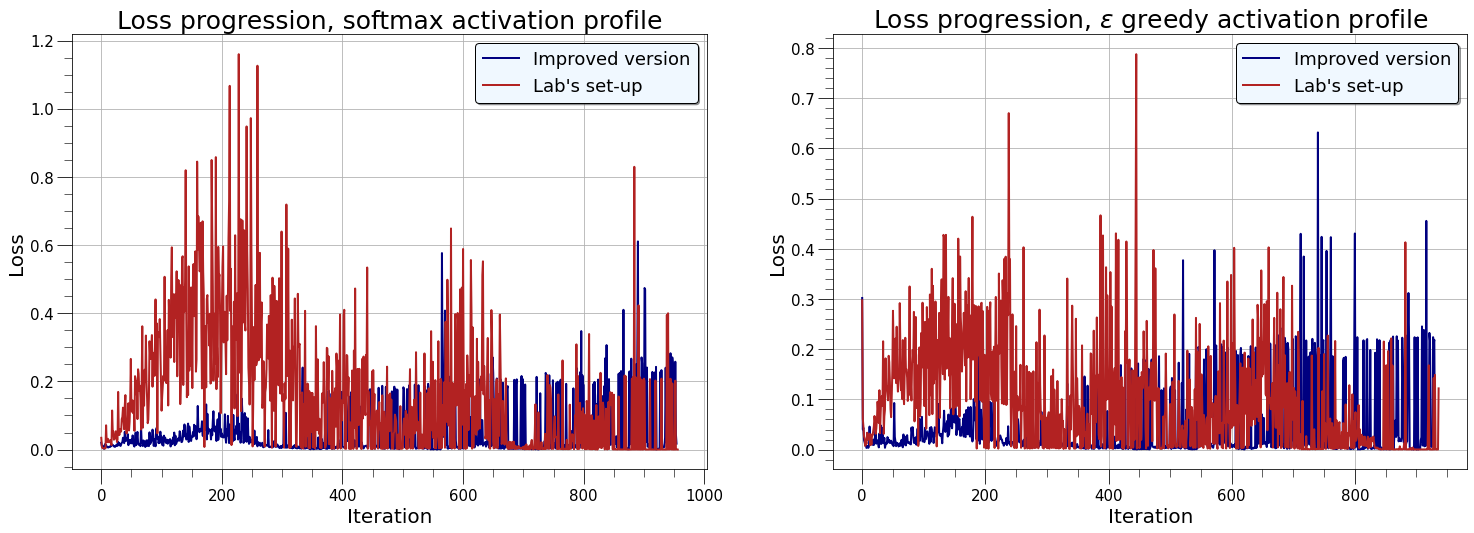

In [117]:
fig, axs = plt.subplots(1, 2, figsize = (25, 8))
ax1, ax2 = axs
ax1.plot(list(map(lambda x: x.detach().numpy(),losses_tuning)), color = 'navy', linewidth = 2, label='Improved version')
ax1.plot(list(map(lambda x: x.detach().numpy(),losses_soft)), color = 'firebrick', linewidth = 2, label='Lab\'s set-up')
ax1.set_title('Loss progression, softmax activation profile', fontsize = 25)

ax2.plot(list(map(lambda x: x.detach().numpy(),losses_tuning_eps)), color = 'navy', linewidth = 2, label='Improved version')
ax2.plot(list(map(lambda x: x.detach().numpy(),losses_epsilon)), color = 'firebrick', linewidth = 2, label='Lab\'s set-up')
ax2.set_title('Loss progression, $\epsilon$ greedy activation profile', fontsize = 25)


for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=15, length=15)
    ax.tick_params(axis='both', which='minor', labelsize=15, length=8)
    ax.minorticks_on()
    ax.set_ylabel('Loss', fontsize = 20)
    ax.set_xlabel('Iteration', fontsize = 20)
    ax.grid()
    ax.legend(facecolor = 'aliceblue', shadow = True, edgecolor = 'black', fontsize =18, loc = 'upper right')



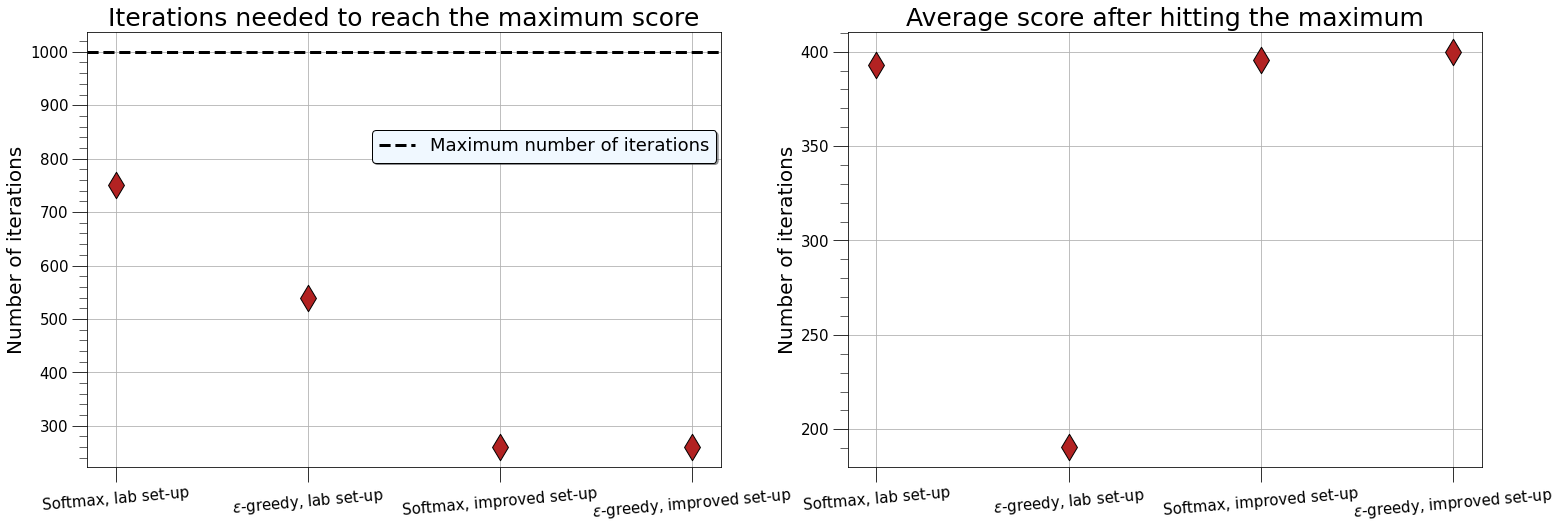

In [178]:
fig, ax = plt.subplots(1, 2, figsize = (25, 8))
ax1, ax2 = ax
argmaxs = [np.argmax(scores_soft), np.argmax(scores_epsilon), np.argmax(scores_tuning), np.argmax(scores_tuning)]
scores = [scores_soft, scores_epsilon, scores_tuning, scores_tuning_eps]
ax1.scatter(x = range(len(argmaxs)), y = argmaxs, marker='d', s= 350, edgecolor = 'black', color='firebrick', zorder = 2)
ax1.axhline(1000, linewidth = 3, linestyle = '--', color = 'black', label = 'Maximum number of iterations')
ax1.minorticks_on()
ax1.tick_params(axis='both', which='major', labelsize=15, length=15)
ax1.tick_params(axis='y', which='minor', labelsize=15, length=8)
ax1.tick_params(axis='x', which='minor', labelsize=15, length=0)
ax1.set_xticks(range(len(argmaxs)))
ax1.set_xticklabels(['Softmax, lab set-up', '$\epsilon$-greedy, lab set-up', 'Softmax, improved set-up',\
     '$\epsilon$-greedy, improved set-up'], rotation = 5)
ax1.grid(zorder = 1)
ax1.set_ylabel('Number of iterations', fontsize = 20)
ax1.set_title('Iterations needed to reach the maximum score', fontsize = 25)
ax1.legend(facecolor = 'aliceblue', shadow = True, edgecolor = 'black', fontsize =18, loc=[0.45,0.7])



means = [np.mean(score[i:]) for score, i in zip(scores , argmaxs)]
ax2.scatter(x = range(len(argmaxs)), y = means, marker='d', s= 350, edgecolor = 'black', color='firebrick', zorder = 2)

ax2.minorticks_on()
ax2.tick_params(axis='both', which='major', labelsize=15, length=15)
ax2.tick_params(axis='y', which='minor', labelsize=15, length=8)
ax2.tick_params(axis='x', which='minor', labelsize=15, length=0)
ax2.set_xticks(range(len(argmaxs)))
ax2.set_xticklabels(['Softmax, lab set-up', '$\epsilon$-greedy, lab set-up', 'Softmax, improved set-up',\
     '$\epsilon$-greedy, improved set-up'], rotation = 5)
ax2.grid(zorder = 1)
ax2.set_ylabel('Number of iterations', fontsize = 20)
ax2.set_title('Average score after hitting the maximum', fontsize = 25)

plt.show()

# Acrobot
In this upcoming section of the notebook we try to train another *Gym* environment, the *Acrobot* environment, described in the following.

The system consists of two links connected linearly to form a chain, with one end of the chain fixed.<br>
The goal is to apply torques on the actuated joint to swing the free end of the linear chain above a given height while starting from the initial state of hanging downwards.
<center>


### Action Space
The action space is discrete and deterministic.


| Num | Action                                | Unit         |
|:-----:|:---------------------------------------:|:--------------:|
| 0   | apply -1 torque to the actuated joint | torque (N $\cdot$ m) |
| 1   | apply 0 torque to the actuated joint  | torque (N $\cdot$ m) |
| 2   | apply 1 torque to the actuated joint  | torque (N $\cdot$ m) |

### Observation Space
| Num | Observation                  | Min                 | Max               |
|:-----:|:------------------------------:|:---------------------:|:-------------------:|
| 0   | Cosine of `theta1`           | -1                  | 1                 |
| 1   | Sine of `theta1`             | -1                  | 1                 |
| 2   | Cosine of `theta2`           | -1                  | 1                 |
| 3   | Sine of `theta2`             | -1                  | 1                 |
| 4   | Angular velocity of `theta1` | ~ -12.567 (-4 * $\pi$) | ~ 12.567 (4 * $\pi$) |
| 5   | Angular velocity of `theta2` | ~ -28.274 (-9 * $\pi$) | ~ 28.274 (9 * $\pi$) |


</center>


where
- `theta1` is the angle of the first joint, where an angle of 0 indicates the first link is pointing directly
    downwards.
- `theta2` is relative to the angle of the first link.
        An angle of $0$ corresponds to having the same angle between the two links.

Both of the angles values are bounded.

### Rewards
The goal is to have the free end reach a designated target height in as few steps as possible, and as such all steps that do not reach the goal incur a reward of $-1$. Achieving the target height results in termination with a reward of $0$.

### Episode End
The episode ends if one of the following occurs:
- Termination: The free end reaches the target height.

- Truncation: Episode length is greater than $500$.

In [189]:
env = gym.make('Acrobot-v1')
env.seed(0)

state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"State space size: {state_space_dim}")
print(f"Action space size: {action_space_dim}")
print('Action space type:', env.action_space)

State space size: 6
Action space size: 3
Action space type: Discrete(3)


## Model parameters

In this implementation we make the following choices:

- We use the same ReplayMemory class as above.

- We use the same feed-forward neural network as defined in the DQN class.

- In this case we do not use the Huber loss but we opt for the standard Mean Squared Error.

- The `bad_state_penalty` parameter is kept at $-0.2$.

- Following the results obtained above we decide to define Adam as our optimizer.

In [190]:
for num_episode in range(10): 
    state = env.reset()
    score = 0
    done = False
    # Go on until the pole falls off or the score reach -500
    while not done and score > -500:
      # Choose a random action
      action = random.choice([0, 1, 2])
      next_state, reward, done, info = env.step(action)
      # Visually render the environment 
      #env.render()
      # Update the final score (-1 for each step)
      score += reward 
      state = next_state
      # Check if the episode ended (the pole fell down)
    print(f"Episode {num_episode + 1} - Final score: {score}") 

Episode 1 - Final score: -500.0
Episode 2 - Final score: -500.0
Episode 3 - Final score: -500.0
Episode 4 - Final score: -500.0
Episode 5 - Final score: -500.0
Episode 6 - Final score: -500.0
Episode 7 - Final score: -500.0
Episode 8 - Final score: -500.0
Episode 9 - Final score: -500.0
Episode 10 - Final score: -500.0


In [191]:
gamma = 0.99  
replay_memory_capacity = 10000   
lr = 1e-3
target_net_update_steps = 10   
batch_size = 256   
bad_state_penalty = -0.2   
min_samples_for_training = 1000  
state_space_dim = 6
action_space_dim = 3

# replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

# policy network
policy_net = DQN(state_space_dim, action_space_dim)

# target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

loss_fn = nn.MSELoss()

In [193]:
# Initialize the Gym environment
env = gym.make('Acrobot-v1') 
env.seed(0)  # Set a random seed for the environment (reproducible results)
   



scores_acrobot = []
losses_acrobot = []
for episode_num, tau in enumerate(tqdm(exploration_profile_soft)):

    state = env.reset()
    score = 0
    done = False

    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      next_state, reward, done, info = env.step(action)

      # Update the final score (-1 for each step)
      score += reward

      if done:  
          reward += bad_state_penalty
          next_state = None
      
      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          loss = update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment 
      env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
    
    scores_acrobot.append(score)
    if len(replay_mem) > min_samples_for_training:
        losses_acrobot.append(loss)
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: -500.0 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: -500.0 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: -500.0 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: -500.0 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: -500.0 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: -500.0 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: -500.0 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: -500.0 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: -500.0 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: -500.0 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: -500.0 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: -500.0 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: -500.0 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: -500.0 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: -50

In [195]:
replay_mem = ReplayMemory(replay_memory_capacity)    

# policy network
policy_net = DQN(state_space_dim, action_space_dim)

# target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr)

In [196]:
# Initialize the Gym environment
env = gym.make('Acrobot-v1') 
env.seed(0)  # Set a random seed for the environment (reproducible results)
   



scores_acrobot_eps = []
losses_acrobot_eps = []
for episode_num, eps in enumerate(tqdm(exploration_profile_eps)):

    state = env.reset()
    score = 0
    done = False

    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_epsilon_greedy(policy_net, state, epsilon=eps)
      
      next_state, reward, done, info = env.step(action)

      # Update the final score (-1 for each step)
      score += reward

      if done:  
          reward += bad_state_penalty
          next_state = None
      
      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          loss = update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment 
      #env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
    
    scores_acrobot_eps.append(score)
    if len(replay_mem) > min_samples_for_training:
        losses_acrobot_eps.append(loss)
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Epsilon: {tau}") # Print the final score

env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: -500.0 - Epsilon: 0.00032310508900658505
EPISODE: 2 - FINAL SCORE: -500.0 - Epsilon: 0.00032310508900658505
EPISODE: 3 - FINAL SCORE: -500.0 - Epsilon: 0.00032310508900658505
EPISODE: 4 - FINAL SCORE: -500.0 - Epsilon: 0.00032310508900658505
EPISODE: 5 - FINAL SCORE: -500.0 - Epsilon: 0.00032310508900658505
EPISODE: 6 - FINAL SCORE: -500.0 - Epsilon: 0.00032310508900658505
EPISODE: 7 - FINAL SCORE: -500.0 - Epsilon: 0.00032310508900658505
EPISODE: 8 - FINAL SCORE: -500.0 - Epsilon: 0.00032310508900658505
EPISODE: 9 - FINAL SCORE: -500.0 - Epsilon: 0.00032310508900658505
EPISODE: 10 - FINAL SCORE: -500.0 - Epsilon: 0.00032310508900658505
Updating target network...
EPISODE: 11 - FINAL SCORE: -500.0 - Epsilon: 0.00032310508900658505
EPISODE: 12 - FINAL SCORE: -500.0 - Epsilon: 0.00032310508900658505
EPISODE: 13 - FINAL SCORE: -500.0 - Epsilon: 0.00032310508900658505
EPISODE: 14 - FINAL SCORE: -500.0 - Epsilon: 0.00032310508900658505
EPI

## Results 

From the progression of the scores we notice that the model gets over the treshold height pretty quickly and then progressively does it in less and less time.<br>
In this specific run the **$\epsilon$-greedy** policy seems to outperform the **Softmax** one.

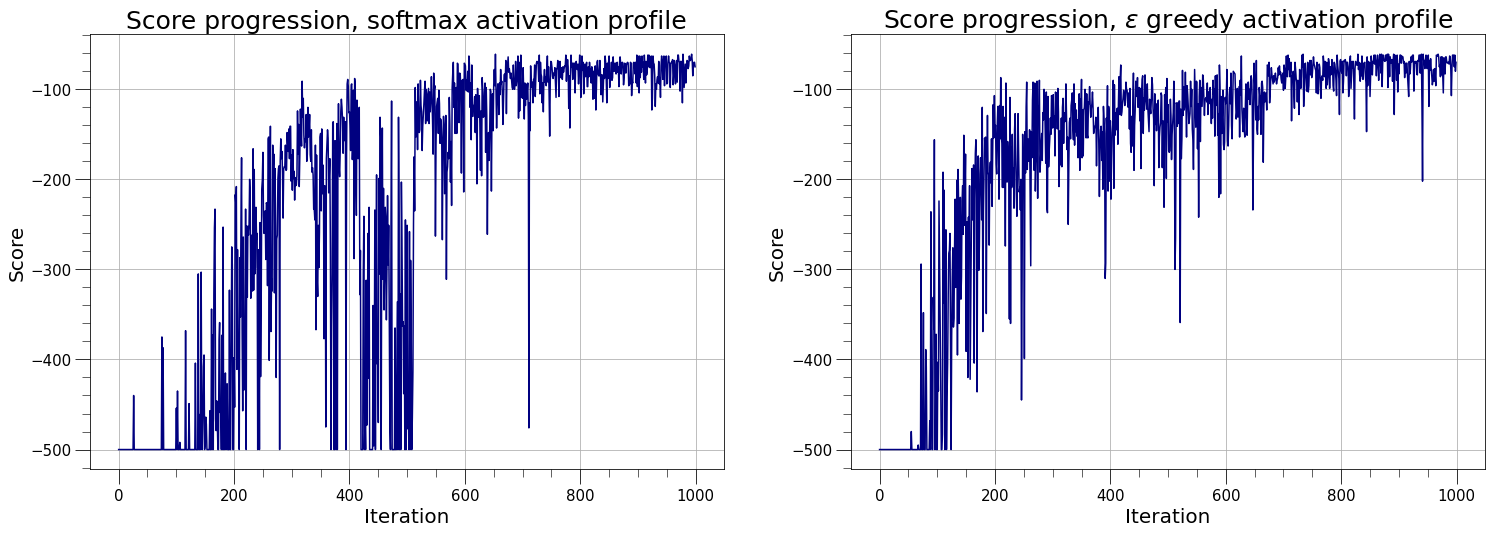

In [197]:
fig, axs = plt.subplots(1, 2, figsize = (25, 8))
ax1, ax2 = axs
ax1.plot(scores_acrobot, color = 'navy')
ax1.set_title('Score progression, softmax activation profile', fontsize = 25)

ax2.plot(scores_acrobot_eps, color = 'navy')
ax2.set_title('Score progression, $\epsilon$ greedy activation profile', fontsize = 25)


for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=15, length=15)
    ax.tick_params(axis='both', which='minor', labelsize=15, length=8)
    ax.minorticks_on()
    ax.set_ylabel('Score', fontsize = 20)
    ax.set_xlabel('Iteration', fontsize = 20)
    ax.grid()
    



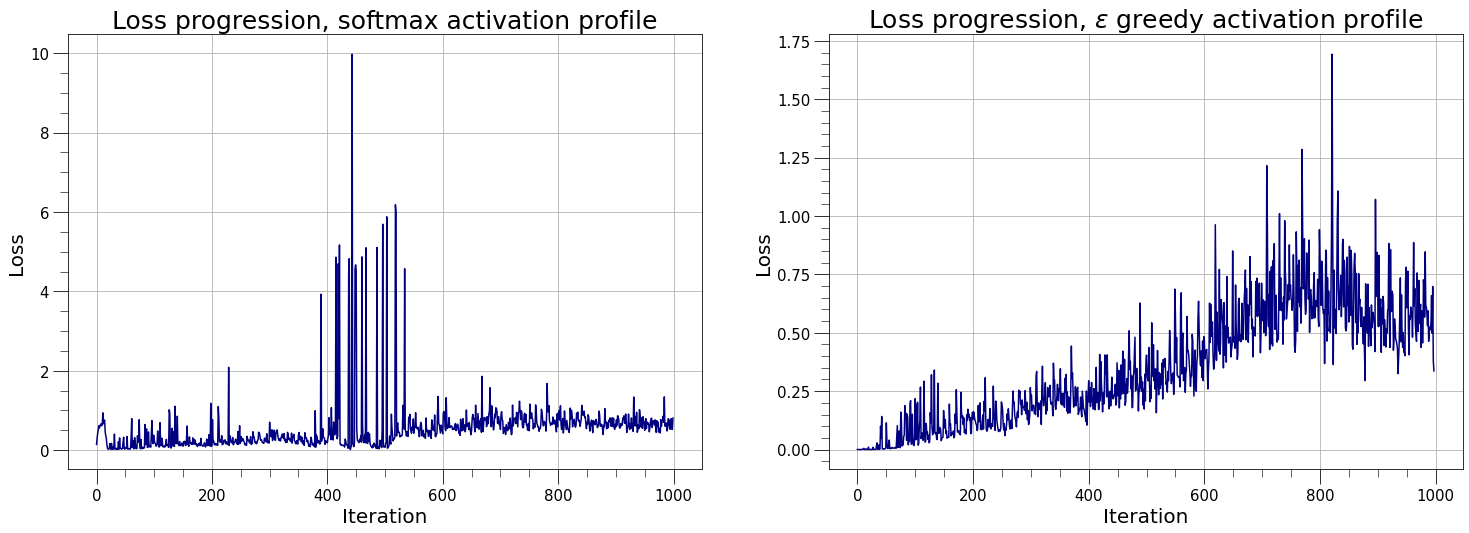

In [198]:
fig, axs = plt.subplots(1, 2, figsize = (25, 8))
ax1, ax2 = axs
ax1.plot(list(map(lambda x: x.detach().numpy(),losses_acrobot)), color = 'navy')
ax1.set_title('Loss progression, softmax activation profile', fontsize = 25)

ax2.plot(list(map(lambda x: x.detach().numpy(),losses_acrobot_eps)), color = 'navy')
ax2.set_title('Loss progression, $\epsilon$ greedy activation profile', fontsize = 25)


for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=15, length=15)
    ax.tick_params(axis='both', which='minor', labelsize=15, length=8)
    ax.minorticks_on()
    ax.set_ylabel('Loss', fontsize = 20)
    ax.set_xlabel('Iteration', fontsize = 20)
    ax.grid()
    



# Make mountain car example

We implement another *Gym* example, the mountain car example, described in the following.

The system is a deterministic one that consists of a car placed stochastically at the bottom of a sinusoidal valley. the only possible actions are the accelerations that can be applied to the car in either direction.<br>
The goal is to strategically apply acceleration to the car in order tho reach the peak of a hill. The actions in this example are discrete.


### Observation Space

<center>

| Num | Observation                          | Min  | Max | Unit         |
|:-----:|:--------------------------------------:|:------:|:-----:|:--------------:|
| 0   | position of the car along the x-axis | -Inf | Inf | position (m) |
| 1   | velocity of the car                  | -Inf | Inf | position (m) |

</center>

### Action Space
There are 3 discrete deterministic actions:

<center>

| Num | Observation             | Value | Unit         |
|:-----:|:-------------------------:|:-------:|:--------------:|
| 0   | Accelerate to the left  | Inf   | position (m) |
| 1   | Don't accelerate        | Inf   | position (m) |
| 2   | Accelerate to the right | Inf   | position (m) |

</center>


### Reward:
The agent is penalised with a reward of $-1$ for each timestep in which the car does not reach the top of the hill.


### Starting State
The position of the car is assigned a uniform random value in `[-0.6 , -0.4]`.
The starting velocity of the car is always assigned to $0$.

### Episode End
The episode ends if either of the following happens:
- Termination: The position of the car is greater than or equal to $0.5$ (the goal position on top of the right hill)
- Truncation: The length of the episode is $200$.

In this example we make similar choces to the *Acrobot* one reusing the *DQN* and *ReplayMemory* classes used for the *CartPole*.<br>
Also here we make the choice to perform the training both with a **Softmax** and **$\epsilon$-greedy** policy.

In [17]:
env = gym.make('MountainCar-v0')
env.seed(0)

state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"State space size: {state_space_dim}")
print(f"Action space size: {action_space_dim}")
print('Action space type:', env.action_space)

State space size: 2
Action space size: 3
Action space type: Discrete(3)


In [18]:
for num_episode in range(10): 
    state = env.reset()
    score = 0
    done = False
    # Go on until the pole falls off or the score reach -500
    while not done and score > -500:
      # Choose a random action
      action = random.choice([0, 1, 2])
      next_state, reward, done, info = env.step(action)
      # Visually render the environment 
      #env.render()
      # Update the final score (-1 for each step)
      score += reward 
      state = next_state
      # Check if the episode ended (the pole fell down)
    print(f"Episode {num_episode + 1} - Final score: {score}") 

Episode 1 - Final score: -200.0
Episode 2 - Final score: -200.0
Episode 3 - Final score: -200.0
Episode 4 - Final score: -200.0
Episode 5 - Final score: -200.0
Episode 6 - Final score: -200.0
Episode 7 - Final score: -200.0
Episode 8 - Final score: -200.0
Episode 9 - Final score: -200.0
Episode 10 - Final score: -200.0


In [20]:
state

array([-0.6462203 , -0.00113145], dtype=float32)

In [19]:
gamma = 0.99  
replay_memory_capacity = 10000   
lr = 1e-3
target_net_update_steps = 10   
batch_size = 256   
bad_state_penalty = -1   
min_samples_for_training = 1000  
state_space_dim = 2
action_space_dim = 3

# replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

# policy network
policy_net = DQN(state_space_dim, action_space_dim)

# target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

loss_fn = nn.MSELoss()

In [23]:
# Initialize the Gym environment
env = gym.make('MountainCar-v0') 
env.seed(0)  # Set a random seed for the environment (reproducible results)
   



scores_car = []
losses_car = []
for episode_num, tau in enumerate(tqdm(exploration_profile_soft)):

    state = env.reset()
    score = 0
    done = False

    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      next_state, reward, done, info = env.step(action)

      # Update the final score (-1 for each step)
      score += reward
    

      if done:  
          reward += bad_state_penalty
          next_state = None
      
      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          loss = update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment 
      #env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
    
    scores_car.append(score)
    if len(replay_mem) > min_samples_for_training:
        losses_car.append(loss)
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1665/3310366229.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1656352448001/work/torch/csrc/utils/tensor_new.cpp:204.)
  states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)


Updating target network...
EPISODE: 1 - FINAL SCORE: -200.0 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: -200.0 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: -200.0 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: -200.0 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: -200.0 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: -200.0 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: -200.0 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: -200.0 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: -200.0 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: -200.0 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: -200.0 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: -200.0 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: -200.0 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: -200.0 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: -20

In [26]:
replay_mem = ReplayMemory(replay_memory_capacity)    

# policy network
policy_net = DQN(state_space_dim, action_space_dim)

# target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr)

In [27]:
# Initialize the Gym environment
env = gym.make('MountainCar-v0') 
env.seed(0)  # Set a random seed for the environment (reproducible results)
   



scores_car_eps = []
losses_car_eps = []
for episode_num, eps in enumerate(tqdm(exploration_profile_eps)):

    state = env.reset()
    score = 0
    done = False

    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_epsilon_greedy(policy_net, state, epsilon=eps)
      
      next_state, reward, done, info = env.step(action)

      # Update the final score (-1 for each step)
      score += reward

      if done:  
          reward += bad_state_penalty
          next_state = None
      
      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          loss = update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment 
      #env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
    
    scores_car_eps.append(score)
    if len(replay_mem) > min_samples_for_training:
        losses_car_eps.append(loss)
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Epsilon: {tau}") # Print the final score

env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: -200.0 - Epsilon: 0.00032310508900658505
EPISODE: 2 - FINAL SCORE: -200.0 - Epsilon: 0.00032310508900658505
EPISODE: 3 - FINAL SCORE: -200.0 - Epsilon: 0.00032310508900658505
EPISODE: 4 - FINAL SCORE: -200.0 - Epsilon: 0.00032310508900658505
EPISODE: 5 - FINAL SCORE: -200.0 - Epsilon: 0.00032310508900658505
EPISODE: 6 - FINAL SCORE: -200.0 - Epsilon: 0.00032310508900658505
EPISODE: 7 - FINAL SCORE: -200.0 - Epsilon: 0.00032310508900658505
EPISODE: 8 - FINAL SCORE: -200.0 - Epsilon: 0.00032310508900658505
EPISODE: 9 - FINAL SCORE: -200.0 - Epsilon: 0.00032310508900658505
EPISODE: 10 - FINAL SCORE: -200.0 - Epsilon: 0.00032310508900658505
Updating target network...
EPISODE: 11 - FINAL SCORE: -200.0 - Epsilon: 0.00032310508900658505
EPISODE: 12 - FINAL SCORE: -200.0 - Epsilon: 0.00032310508900658505
EPISODE: 13 - FINAL SCORE: -200.0 - Epsilon: 0.00032310508900658505
EPISODE: 14 - FINAL SCORE: -200.0 - Epsilon: 0.00032310508900658505
EPI

## Results

Looking at the 2 progressions, the **$\epsilon$-greedy** one seems to be better both in terms of the first iteration the car reaches the goal and the average oterations needed to reach `x = 0.5` after that.

At first glance it seems that the learning curve is worst then in the *Acrobot* case but what we should keep in mind that in the *Acrobot* the episode stopped after 500 steps while now it stops after only 200.

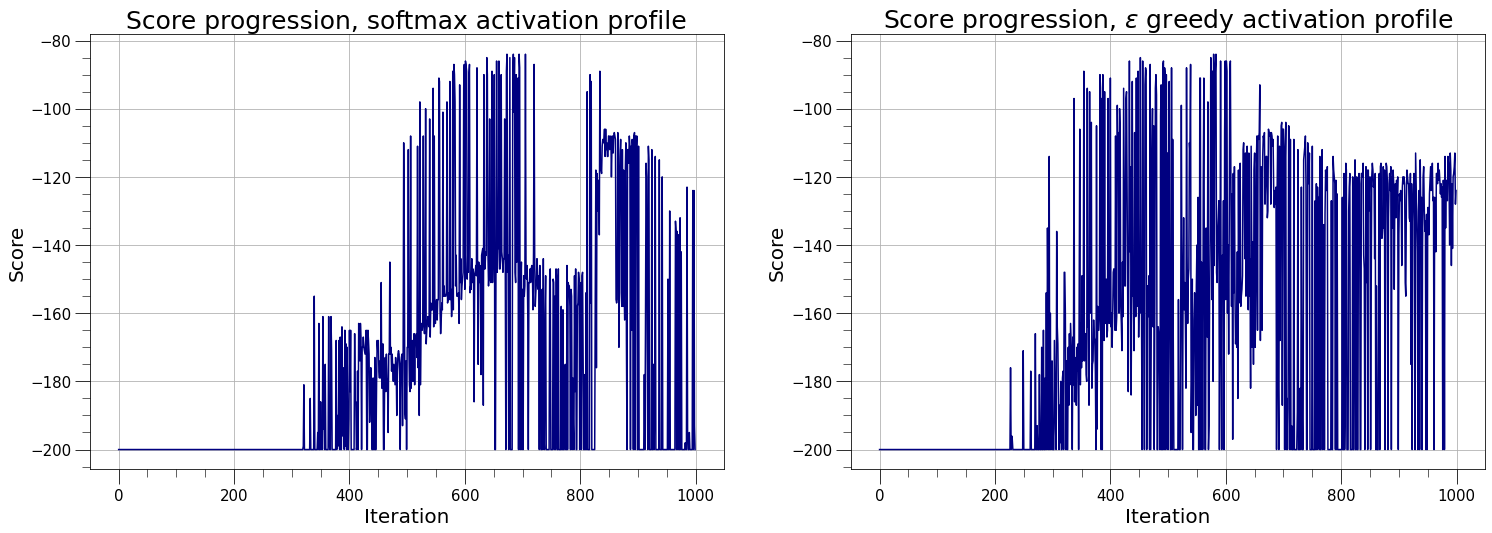

In [29]:
fig, axs = plt.subplots(1, 2, figsize = (25, 8))
ax1, ax2 = axs
ax1.plot(scores_car, color = 'navy')
ax1.set_title('Score progression, softmax activation profile', fontsize = 25)

ax2.plot(scores_car_eps, color = 'navy')
ax2.set_title('Score progression, $\epsilon$ greedy activation profile', fontsize = 25)


for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=15, length=15)
    ax.tick_params(axis='both', which='minor', labelsize=15, length=8)
    ax.minorticks_on()
    ax.set_ylabel('Score', fontsize = 20)
    ax.set_xlabel('Iteration', fontsize = 20)
    ax.grid()
    



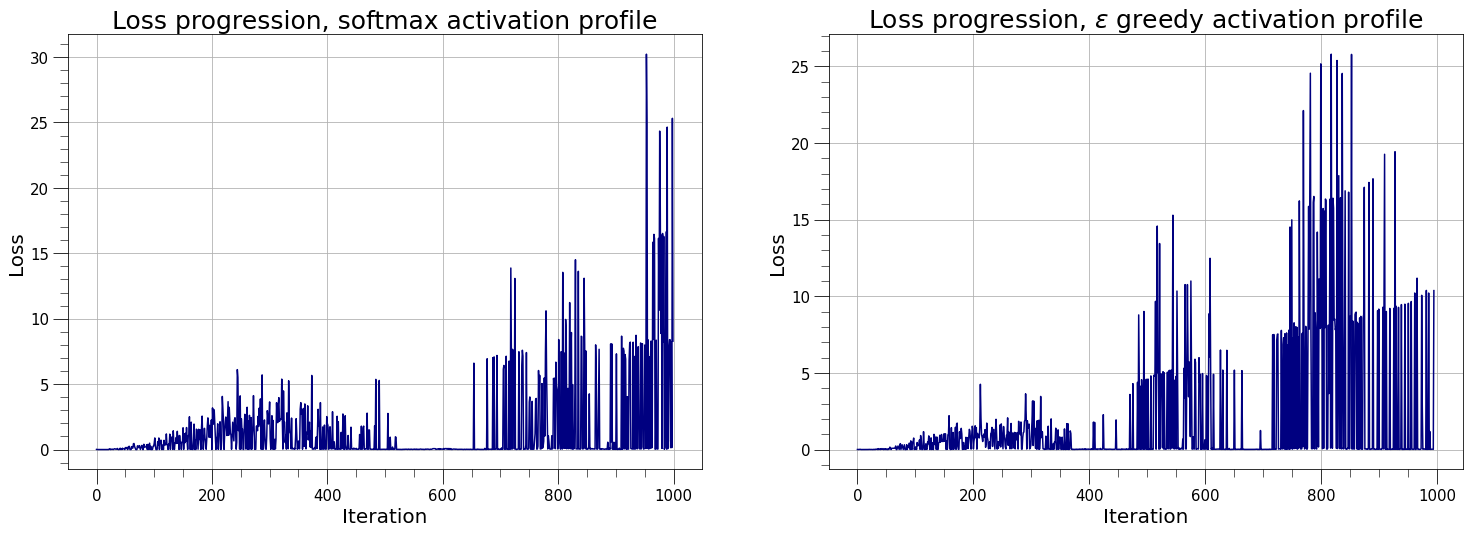

In [30]:
fig, axs = plt.subplots(1, 2, figsize = (25, 8))
ax1, ax2 = axs
ax1.plot(list(map(lambda x: x.detach().numpy(),losses_car)), color = 'navy')
ax1.set_title('Loss progression, softmax activation profile', fontsize = 25)

ax2.plot(list(map(lambda x: x.detach().numpy(),losses_car_eps)), color = 'navy')
ax2.set_title('Loss progression, $\epsilon$ greedy activation profile', fontsize = 25)


for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=15, length=15)
    ax.tick_params(axis='both', which='minor', labelsize=15, length=8)
    ax.minorticks_on()
    ax.set_ylabel('Loss', fontsize = 20)
    ax.set_xlabel('Iteration', fontsize = 20)
    ax.grid()
    

